Analyse campagne 2018
===========

Dans ce notebook on présente les résultats de l'analyse des données de la campagne 2018. N'hésitez pas à faire varier les paramètres des fonctions grâce aux différents menus déroulants, voire à modifier le code (vous pouvez l'afficher ou le cacher grâce au bouton ci-dessous). La plupart des fonctions d'analyses utilisées sont définies dans fichier `analyse.py` et sont seulement appelées ici pour en afficher les résultats.

# Sommaire
* **[I. Présentation graphique](#I.-Présentation-graphique)**
* **[II. Présentation des procédures d'analyse](#II.-Présentation-des-procédures-d'analyse)**
    * [II.1. Stratégie de représentation des annotations](#II.1.-Stratégie-de-représentation-des-annotations)
    * [II.2. Mesure de consensus](#II.2.-Mesure-de-consensus)
* **[III. Recherche de différence entre les textes témoins et les textes à rupture](#III.-Recherche-de-différence-entre-les-textes-témoins-et-les-textes-à-rupture)**
    * [III.1. Ruptures de la frontière droite](#III.1.-Ruptures-de-la-frontière-droite)
    * [III.2. Remontées sans complétude de la sous structure](#III.2.-Remontées-sans-complétude-de-la-sous-structure)
    * [III.3. Consensus par texte](#III.3.-Consensus-par-texte)
* **[IV. Recherche de consensus sur les interventions du psychologue](#IV.-Recherche-de-consensus-sur-les-interventions-du-psychologue)**
* **[V. Consensus sur les types de relations](#V.-Consensus-sur-les-types-de-relations)**
* **[VI. Clusters d'annotateurs](#VI.-Clusters-d'annotateurs)**
    * [VI.1. Clusters pour chaque texte](#VI.1.-Clusters-pour-chaque-texte)
    * [VI.2. Addition de plusieurs textes](#VI.2.-Addition-de-plusieurs-textes)

In [1]:
# Customization du notebook pour que ce soit plus lisible et agréable à utiliser
%matplotlib notebook
%matplotlib notebook
from IPython.core.display import display, HTML

# Augmentation de la largeur de la fenêtre
display(HTML("<style>.container { width:95% !important; }</style>"))

# On fait en sorte qu'il n'y ai pas d'ascenseur vertical pour les images générées
display(HTML("<script>IPython.OutputArea.prototype._should_scroll=function(){return false;}</script>"))

#On cache le code
display(HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Afficher/Cacher le code"></form>'''))

import warnings
warnings.filterwarnings('ignore')

In [2]:
from ipywidgets import interact, fixed, FloatSlider, interactive, Button

from os import path

import pandas

from scipy import stats

import matplotlib.pyplot as plt

import operator

from data import Unit, Texte, Campagne, Annotateur, Relation, Annotation, Theme
from parsing2 import parsing
from analyse import *

In [3]:
## Récupérations des données

AnnotationDirectory = "Campagne 2018"
projectDirectory = "../"
textsNames = ["Bac_a_sable", "Florence","Provocation", "Nord", "Concours", "Sauveur", "Volley"]
textDirectories = [path.join(projectDirectory,AnnotationDirectory,t) for t in textsNames]

print("Lecture des fichiers de la campagne...")

camp = parsing(textDirectories)

typesRel = {"Narration":"horizontale", "Réponse":"horizontale", "Elaboration descriptive":"verticale", "Elaboration evaluative":"verticale", "Elaboration prescriptive":"verticale", "Conduite":"verticale","Phatique":"verticale","Contre-élaboration":"verticale","Méta-question":"verticale","Question":"verticale"}
camp.typesRelations = typesRel

nAnnots = 0
for t in textsNames:
    nAnnots += len(camp.getAnnotations(t))
print(nAnnots, "annotations ont été chargées.")

mauvaisesAnnots = supprimerMauvaisesAnnotations(camp)
if len(mauvaisesAnnots) > 0:
    print("\nLes annotations suivantes étaient non conformes et ne seront pas prises en compte :")
    print(mauvaisesAnnots)

Lecture des fichiers de la campagne...
154 annotations ont été chargées.

Les annotations suivantes étaient non conformes et ne seront pas prises en compte :
[('A06', 'Concours'), ('C02', 'Bac_a_sable'), ('C07', 'Florence'), ('C10', 'Provocation'), ('C10', 'Concours'), ('E01', 'Bac_a_sable'), ('E04', 'Sauveur'), ('E06', 'Florence'), ('E10', 'Volley'), ('E11', 'Nord')]


# I. Présentation graphique

In [4]:
# En utilisant juste la fonction interact on ne peut pas récupérer l'objet retourné par la fonction alors on va utiliser interactive. 
# Mais pour ça il faut écrire directement dans la fonction qu'on lui passe ce qu'on veut qu'il affiche (il n'affiche pas automatiquement le return) donc on va encapsuler la fonction de dessin ici
def drawing_tree_wrapper(nomTexte, regroupement, seuilAffichage=0.1, montrerThemes=True):
    dot = draw_global_tree(camp, nomTexte, regroupement, seuilAffichage, montrerThemes)
    display(dot)
    return(dot)

global_tree = interactive(drawing_tree_wrapper, nomTexte=textsNames, regroupement=["aucun", "catégorie", "emplacement"], seuilAffichage=FloatSlider(min=0.,max=1., step=0.05, value=0.1, continuous_update=False))

bEnregistrerGraphe = Button(
    description='Enregistrer',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Enregistrer ce graphe',
    icon='download'
)

def enregistrer(b):
    nom_fichier = global_tree.kwargs['nomTexte'] + "_-_" + global_tree.kwargs['regroupement'] + "_-_" + str(global_tree.kwargs['seuilAffichage'])
    dot = global_tree.result
    dot.format = 'png'
    dot.render(filename=nom_fichier, directory="images_enregistrees", view=True, cleanup=True)
    
bEnregistrerGraphe.on_click(enregistrer)

Nous avons représenté les graphes totaux de toutes les annotations pour chaque texte afin de pouvoir visualiser simplement les solutions majoritaires. Nous pouvons pour chaque texte construire 3 graphes représentant des niveaux d’analyse plus ou moins fins :
- un graphe représentant toutes les relations entre les unités et leur type
- un graphe fusionnant certaines relations entre elles selon des catégories définies
- un graphe fusionnant tous les types de relations et ne présentant donc que l’emplacement des relations

Les catégories que nous avons choisies sont les suivantes :
- *Narration :* Narration
- *Elaborations :* Elaboration descriptive, Elaboration évaluative, Elaboration prescriptive, Contre-élaboration, Réponse
- *Méta :* Conduite, Phatique, Méta-question
- *Question :* Question

Les graphes présentent également, en rouge, le nombre de personnes ayant signalé un changement de thème au niveau de chaque unité.

En outre, pour plus de lisibilité il est possible de choisir un seuil minimal pour l’affichage des relations. 

In [5]:
display(global_tree)
display(bEnregistrerGraphe)

A Jupyter Widget

A Jupyter Widget

D’après ces graphes, il semble que les relations les plus consensuelles soient Question, Réponse et Phatique

Pour tous les textes, il semble que des consensus émergent au niveau de l’emplacement des relations. Les endroits où les rattachement sont les plus dispersés ne semblent pas correspondre aux ruptures conversationnelles que nous avions identifiées, mais plutôt à des unités dont le sens est difficile à saisir (par exemple dans Sauveur : A5_4 : une maison qu’est qu'on a fait qu'on a fait... qu’on a touchée.).  On observe d’ailleurs un consensus sur le type de relation utilisé pour relier cette unité (élaboration descriptive) et elle est toujours reliée à une unité proche (on pourrait dire que les différentes annotations sont équivalentes par transitivité).

# II. Présentation des procédures d'analyse

## II.1. Stratégie de représentation des annotations

La représentation sous forme d'arbre est compliquée à utiliser pour comparer les annotations entre elles. Nous avons donc cherché une autre représentation plus adaptée. Chaque unité n'étant reliée qu'à une seule unité précédente, on peut considérer qu'annoter le texte revient à attribuer une étiquette à chaque unité. Une annotation peut alors être représenté comme l'ensemble des étiquettes mises sur chaque unité par un annotateur. Nous avons distingué 5 manière différentes d'étiqueter les unité, qui résument plus ou moins les arbres pour des anlayses plus ou moins fines. Ainsi pour chaque unité on peut indiquer :
* seulement l'unité rattachée
* la catégorie de la relation utilisée
* le type de la relation utilisée
* l'unité rattachée conjuguée à la catégorie de relation utiliée
* l'unité rattachée conjuguée au type de relation

## II.2. Mesure de consensus

La plupart de nos observations et hypothèses reposent sur la notion de consensus entre les annotateurs. Il nous a donc fallu trouver un moyen de mesurer la convergence des annotations au niveau de chaque unité. Concrètement, cette mesure devait être capable d’indiquer que l’annotation pour une unité est très consensuelle si tous les annotateurs l’ont annoté de la même façon, un peu moins consensuelles si on observe par exemple 2 façons majoritaires d’annoter, et beaucoup moins si les annotations sont très dispersées.

Nous nous sommes donc tournés vers l’entropie de Shannon. Cette mesure permet de calculer le “désordre” dans un ensemble d’objets étiquetés : l’entropie vaut 0 si tous les objets sont du même type et, plus les types sont dispersés, plus l’entropie est élevée. Elle est calculée comme suit :
$ H(X) = -\sum_{i=1}^k P_i log_2 (P_i)$
avec $k$ le nombre d’étiquettes différentes possible et $P_i$ la proportion d’éléments étiquetés $i$.

En utilisant la représentation présentée au paragraphe précédent, on peut donc utiliser l'entropie de Shannon pour mesurer la dispersion des annotations par unité. On peut de plus mesurer 5 types de consensus différents, en utilisant les 5 représentations différentes, selon qu'on veut savoir si le consensus se trouve au niveau du type de relation utilisé ou de leur emplacement par exemple.

# III. Recherche de différence entre les textes témoins et les textes à rupture

In [6]:
nbAnnot = dict()
for nomTexte in camp.textes:
    nbAnnot[nomTexte] = len(camp.getAnnotations(nomTexte))
print("Nombre d'annotations pour chaque texte")
nbAnnot

Nombre d'annotations pour chaque texte


{'Bac_a_sable': 36,
 'Concours': 13,
 'Florence': 17,
 'Nord': 19,
 'Provocation': 21,
 'Sauveur': 16,
 'Volley': 22}

## III.1. Ruptures de la frontière droite

In [8]:
nbRuptures = dict()
for nomTexte in camp.textes:
    nbRuptures[nomTexte] = 0
    for a in camp.getAnnotations(nomTexte):
        if rupturesFrontiereDroite(a):
            nbRuptures[nomTexte] += 1
s_nbRuptures = pandas.Series(nbRuptures)
s_nbAnnot = pandas.Series(nbAnnot)
ratio_ruptures = s_nbRuptures/s_nbAnnot
df_ruptures = pandas.concat((s_nbRuptures, s_nbAnnot, ratio_ruptures), axis=1)
df_ruptures.columns = ["Annotations comportant une rupture", "Annotations totales", "Ratio"]
df_ruptures

,Annotations comportant une rupture,Annotations totales,Ratio
Bac_a_sable,8,36,0.222222
Concours,9,13,0.692308
Florence,7,17,0.411765
Nord,6,19,0.315789
Provocation,9,21,0.428571
Sauveur,6,16,0.375000
Volley,12,22,0.545455


In [9]:
ruptures = dict()
pasRuptures = dict()
for t in list(camp.textes.keys()):
    n = nbRuptures[t]
    ruptures[t] = n
    pasRuptures[t] = nbAnnot[t] - n

pValues_ruptures = pandas.DataFrame(np.zeros((len(camp.textes), len(camp.textes))), camp.textes.keys(), camp.textes.keys())
paires = itertools.combinations(camp.textes.keys(),2)
for t1, t2 in paires:
    contingence = [[ruptures[t1], ruptures[t2]], [pasRuptures[t1], pasRuptures[t2]]]
    pValues_ruptures[t1][t2] = stats.chi2_contingency(contingence)[1]
pValues_ruptures.style.apply(highlight_significant)

,Bac_a_sable,Florence,Provocation,Nord,Concours,Sauveur,Volley
Bac_a_sable,0,0,0,0,0,0,0
Florence,0.269947,0,0,0,0,0,0
Provocation,0.179416,0.821152,0,0,0,0,0
Nord,0.665737,0.801821,0.682716,0,0,0,0
Concours,0.00668374,0.247267,0.252734,0.0826363,0,0,0
Sauveur,0.419289,0.888336,0.992713,0.991852,0.184515,0,0
Volley,0.0258616,0.613385,0.644589,0.245187,0.617178,0.477709,0


In [10]:
draw_p_values(pValues_ruptures, "Tests du Chi² sur le nombre de ruptures", True)

<IPython.core.display.Javascript object>

## III.2. Remontées sans complétude de la sous-structure


In [11]:
nbRemontees = dict()
for nomTexte in camp.textes:
    nbRemontees[nomTexte] = 0
    for a in camp.getAnnotations(nomTexte):
        if a.matrice().iloc[:,:,0].as_matrix().sum() > 1:
            nbRemontees[nomTexte] += 1
s_nbRemontees = pandas.Series(nbRemontees)
ratio_remontees = s_nbRemontees/s_nbAnnot
df_remontees = pandas.concat((s_nbRemontees,s_nbAnnot, ratio_remontees), axis=1)
df_remontees.columns = ["Annotations comportant une rupture", "Annotations totales", "Ratio"]
df_remontees

,Annotations comportant une rupture,Annotations totales,Ratio
Bac_a_sable,1,36,0.027778
Concours,1,13,0.076923
Florence,12,17,0.705882
Nord,6,19,0.315789
Provocation,5,21,0.238095
Sauveur,8,16,0.500000
Volley,1,22,0.045455


<IPython.core.display.Javascript object>


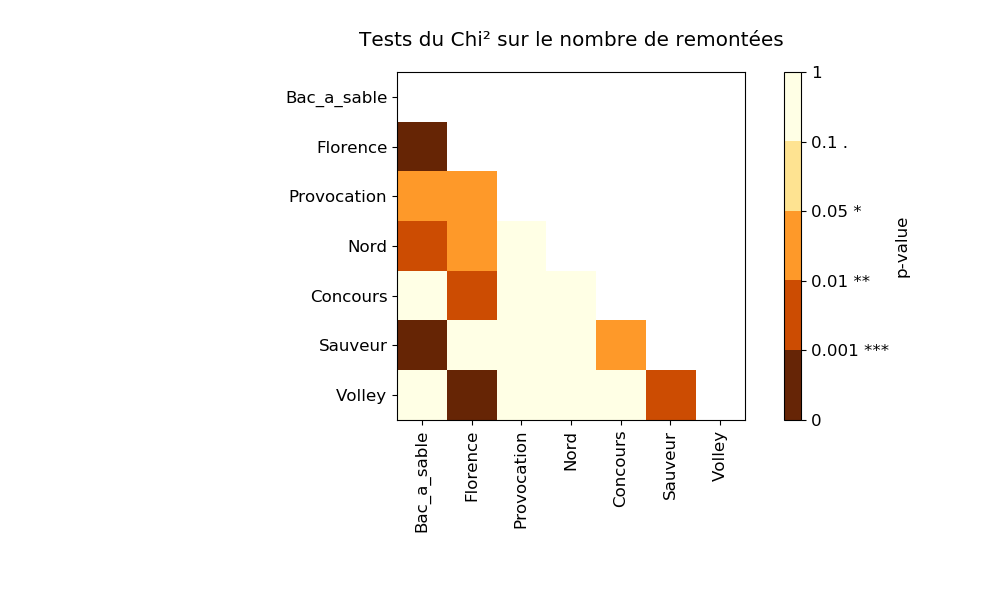

In [13]:
remontees = dict()
pasRemontees = dict()
for t in list(camp.textes.keys()):
    n = nbRemontees[t]
    remontees[t] = n
    pasRemontees[t] = nbAnnot[t] - n

pValues_remontees = pandas.DataFrame(np.zeros((len(camp.textes), len(camp.textes))), camp.textes.keys(), camp.textes.keys())
paires = itertools.combinations(camp.textes.keys(),2)
for t1, t2 in paires:
    contingence = [[remontees[t1], remontees[t2]], [pasRemontees[t1], pasRemontees[t2]]]
    pValues_remontees[t1][t2] = stats.chi2_contingency(contingence)[1]
draw_p_values(pValues_remontees, "Tests du Chi² sur le nombre de remontées", triangulaire=True)

## III.3. Consensus par texte
A partir des mesures de l’entropie pour chaque unité, nous avons calculé la moyenne de l’entropie de chaque texte, afin d’avoir une idée du niveau de consensus global pour chaque texte

In [14]:
criteres = ["emplacement", "categ", "type", "emplacement-type", "emplacement-categ"]
listeEntropies = dict()
moyennes = dict()
for critere in criteres:
    entropies = dict()
    entropie_textes = dict()
    for texte in camp.textes:
        entropie = calculEntropie(camp, texte, critere)
        entropies[texte] = entropie
        entropie_textes[texte] = np.mean(entropie)
    listeEntropies[critere] = entropies
    moyennes[critere] = pandas.Series(entropie_textes)

    
print("Moyenne de l'entropie de chaque texte, pour les 3 critères d'étiquetage : seulement l'emplacement de destination, seulement le type de relation qui part de l'unité, et les deux.")
pandas.concat(moyennes, axis=1)

Moyenne de l'entropie de chaque texte, pour les 3 critères d'étiquetage : seulement l'emplacement de destination, seulement le type de relation qui part de l'unité, et les deux.


,categ,emplacement,emplacement-categ,emplacement-type,type
Bac_a_sable,0.391625,0.547604,0.928644,1.338180,0.864300
Concours,0.764375,0.642413,1.218339,1.533880,1.198180
Florence,0.840821,0.743535,1.456733,1.746756,1.240121
Nord,0.726392,0.725071,1.333981,1.647213,1.075633
Provocation,0.775050,0.758543,1.440933,1.767106,1.171216
Sauveur,0.688891,0.742390,1.317406,1.589954,1.098704
Volley,0.714696,0.653012,1.267928,1.683453,1.197015


On observe une entropie moyenne légèrement plus faible au niveau de l’emplacement des relations pour le texte Bac à sable et les deux textes témoins (Concours et Volley) que pour tous les autres textes, indiquant que ces trois textes sont un peu plus consensuels au niveau de l’emplacement des relations. 
Quel que soit le critère, on observe également une entropie beaucoup plus faible pour le texte Bac à sable que pour tous les autres, mais cela s’explique sans doute en grande partie par le fait que ce texte est beaucoup plus court que les autres et qu’il y a donc moins d’annotations différentes possibles. 

# IV. Recherche de consensus sur les interventions du psychologue
Nous voulons tester si les consensus se situent plus souvent sur les tours de parole du psychologue que du schizophrène.

Pour vérifier cela, notre idée est de tester s’il y a des différences significatives au niveau de la moyenne d’entropie pour les unités du psychologue et du schizophrène


In [15]:
def entropiesRelationsTexte(nomTexte, tri="index"):
    entropiesParTexte = {texte: dict() for texte in camp.textes}

    for critere, textes in listeEntropies.items():
        for texte, entropies in textes.items():
            entropiesParTexte[texte][critere] = entropies
    df = pandas.DataFrame(entropiesParTexte[nomTexte])
    if tri != "index":
        df = df.sort_values(tri)
    return df

interact(entropiesRelationsTexte, nomTexte=camp.textes.keys(), tri=["index", "emplacement", "emplacement-type", "type"])

A Jupyter Widget

<function __main__.entropiesRelationsTexte>

In [16]:
def differenceEntropieParticipant(nomTexte, critere):
    ent = entropiesRelationsTexte(nomTexte)
    entA = list()
    entB = list()
    for u in camp.textes[nomTexte].unites[1:]:
        if u.name[0] == "A":
            entA.append(ent.loc[u.name][critere])
        elif u.name[0] == "B":
            entB.append(ent.loc[u.name][critere])

    fig, ax = plt.subplots(figsize=(3.5,3.5))
    ax.boxplot([entA, entB])
    ax.set_xticklabels(["Psychologue","Patient"])
    plt.title(nomTexte)
    plt.show()
    print(stats.mannwhitneyu(entA, entB))

In [17]:
interact(differenceEntropieParticipant, nomTexte=camp.textes.keys(), critere=["emplacement", "type", "emplacement-type"])

A Jupyter Widget

<function __main__.differenceEntropieParticipant>

In [18]:
p_values = dict()
moyennesA = dict()
moyennesB = dict()
for nomTexte in camp.textes:
    ent = entropiesRelationsTexte(nomTexte)
    entA = list()
    entB = list()
    for u in camp.textes[nomTexte].unites[1:]:
        if u.name[0] == "A":
            entA.append(ent.loc[u.name]["emplacement"])
        elif u.name[0] == "B":
            entB.append(ent.loc[u.name]["emplacement"])
    moyennesA[nomTexte] = np.mean(entA)
    moyennesB[nomTexte] = np.mean(entB)
    p_values[nomTexte] = stats.mannwhitneyu(entA, entB)[1]
s1 = pandas.Series(moyennesA)
s2 = pandas.Series(moyennesB)
pandas.concat((s1,s2), axis=1)

pandas.Series(p_values)

Bac_a_sable    0.428568
Concours       0.429999
Florence       0.019391
Nord           0.015212
Provocation    0.024593
Sauveur        0.079858
Volley         0.309780
dtype: float64

In [19]:
p_values = pandas.DataFrame(np.zeros((len(camp.textes), 3)), camp.textes.keys(), ["emplacement", "type", "emplacement-type"])
for nomTexte in camp.textes:
    for critere in ["emplacement", "type", "emplacement-type"]:
        ent = entropiesRelationsTexte(nomTexte)
        entA = list()
        entB = list()
        for u in camp.textes[nomTexte].unites[1:]:
            if u.name[0] == "A":
                entA.append(ent.loc[u.name][critere])
            elif u.name[0] == "B":
                entB.append(ent.loc[u.name][critere])
        p_values.loc[nomTexte, critere] = stats.mannwhitneyu(entA, entB)[1]

def highlight_significant(data):
    is_significant = data < 0.05
    return ['background-color: green' if v else '' for v in is_significant]

p_values.style.apply(highlight_significant)


,emplacement,type,emplacement-type
Bac_a_sable,0.428568,0.18838,0.297942
Florence,0.019391,0.330056,0.0713425
Provocation,0.0245928,0.0698481,0.455962
Nord,0.0152119,0.463106,0.0695434
Concours,0.429999,0.194526,0.321633
Sauveur,0.0798581,0.0382967,0.0582044
Volley,0.30978,0.11812,0.134751


Il faudrait faire un tableau récapitulatif avec toutes les p-values. Faire le total serait bien aussi.

# V. Consensus sur les types de relations

Une de nos hypothèses est que certains types de relations (i.e. les Questions, les Réponses et les Phatiques) donnent plus souvent lieu à des consensus que les autres. Pour tester cela, nous avons tout d’abord essayé de comparer la proportion de chaque type de relation sur toutes les unités où elle était présente. Pour chaque type de relation, nous avons fait la liste de toutes ses proportions différentes de 0 et nous avons essayé d’en analyser la distribution. Par exemple, si "Narration" correspond à 100% des relations qui partent de A1, 0% de B2, 15% de A3, etc. nous lui assignons la série [1, 0.15, ...]. Les différents textes comportant chacun plus ou moins d'un type ou d'un autre de relations, nous avons choisi de fusionner les résultats de tous les textes.

In [20]:
relationsParTexte = dict()
for texte in camp.textes:
    annotations = camp.getAnnotations(texte)
    matrices = [a.matrice() for a in annotations]
    matriceTotale = matrices[0].copy()
    for mat in matrices[1:]:
        matriceTotale = matriceTotale.add(mat)
    count = dict()
    for rel in camp.typesRelations:
        mat = matriceTotale[rel].as_matrix()
        count[rel] = mat[np.nonzero(mat)] / len(annotations)
    relationsParTexte[texte] = count
    
relationsTotales = {rel : [] for rel in camp.typesRelations}
for texte in camp.textes:
    for rel in camp.typesRelations:
        relationsTotales[rel] += list(relationsParTexte[texte][rel])

In [21]:
def dessinerRelationsParTexte(nomTexte):
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111)
    bp = ax.boxplot(relationsParTexte[nomTexte].values(), whis="range")
    ax.set_xticklabels(relationsParTexte[nomTexte].keys(), rotation="vertical")
    plt.xlabel("Type de relation")
    plt.ylabel("% utilisation pour chaque unité")
    plt.title("Répartition de la proportion de chaque type de relation par unité pour le texte "+nomTexte)
    plt.gcf().subplots_adjust(bottom=0.3)
    plt.show()
    
interact(dessinerRelationsParTexte, nomTexte=camp.textes.keys())

A Jupyter Widget

<function __main__.dessinerRelationsParTexte>

<IPython.core.display.Javascript object>


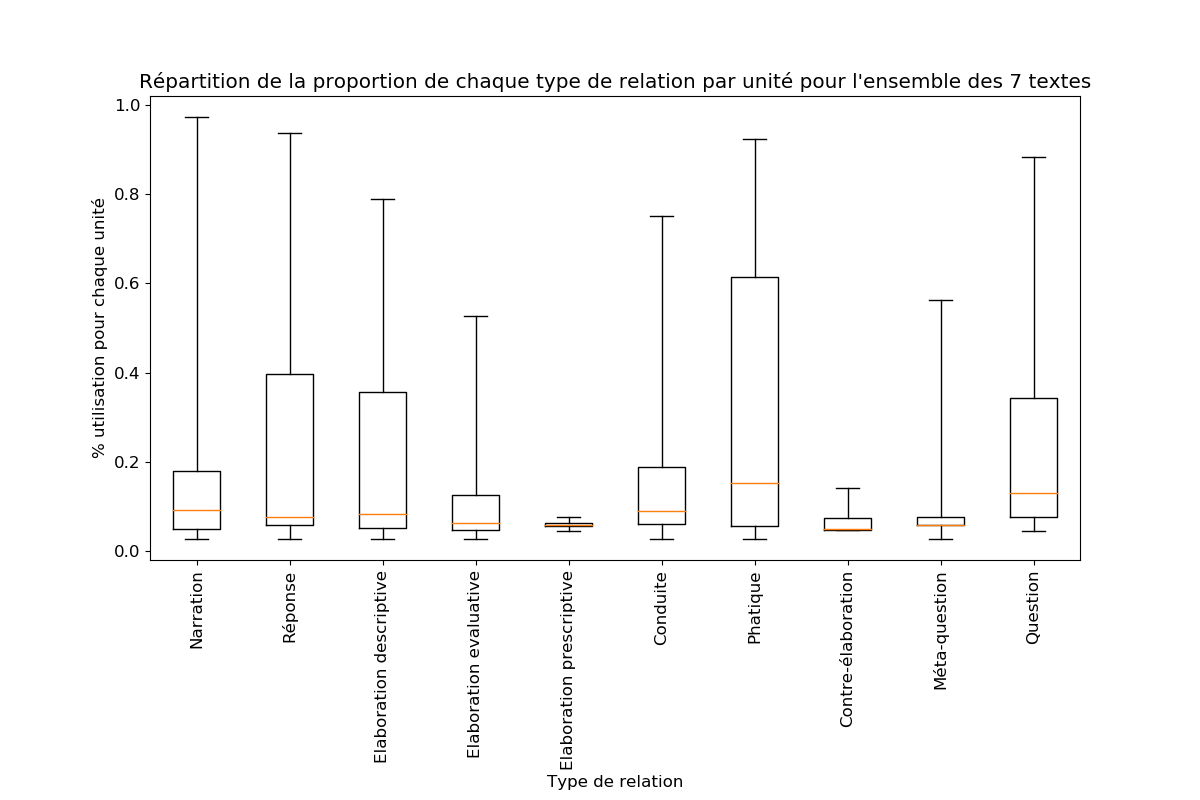

In [22]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
bp = ax.boxplot(relationsTotales.values(), whis="range")
ax.set_xticklabels(relationsTotales.keys(), rotation="vertical")
plt.xlabel("Type de relation")
plt.ylabel("% utilisation pour chaque unité")
plt.title("Répartition de la proportion de chaque type de relation par unité pour l'ensemble des 7 textes")
plt.gcf().subplots_adjust(bottom=0.3)
plt.show()

On observe ici que les relations Phatique, Réponse, et également Question et Elaboration, quand elles sont utilisées pour unité, le sont souvent par une plus grande proportion d’annotateurs que les autres types de relation. Par exemple, dans 25% des cas où la relation Phatique est utilisée (le quartile supérieur), elle est choisie par plus de 60% des annotateurs.

Nous allons effectuer des tests sur la médiane afin de vérifier si certains types de relations sont, pour la plupart des unités où ils sont présents, choisis par un plus grand nombre d'annotateur que d'autres types de relations. Nous effectuons pour cela des tests de Wilcoxon-Mann-Whitney 2 à 2. L'hypothèse nulle est à chaque fois que les distributions des deux groupe sont égales et l'hypothèse alternative que le premier groupe est stochastiquement supérieur au second. Voici les résultats de ces tests (une p-value inférieure à 0.05 indique qu'on peut rejeter l'hypothèse nulle avec moins de 5% de chance de se tromper, et donc accepter l'hypothèse qu'une relation est utilisée dans la plupart des cas conjointement par un plus grand nombre de personnes que l'autre).

In [23]:
paires = itertools.combinations(relationsTotales.keys(), 2)
zeros = np.zeros((len(relationsTotales), len(relationsTotales)))
pValues_relations = pandas.DataFrame(zeros, relationsTotales.keys(), relationsTotales.keys())
#for x, y in paires:
for x in  relationsTotales.keys():
    for y in relationsTotales.keys():
        pValues_relations.loc[x,y] = stats.mannwhitneyu(relationsTotales[x], relationsTotales[y], alternative="greater")[1]
        
print("P-values des tests de Wilcoxon-Mann-Whitney")
pValues_relations

P-values des tests de Wilcoxon-Mann-Whitney


,Narration,Réponse,Elaboration descriptive,Elaboration evaluative,Elaboration prescriptive,Conduite,Phatique,Contre-élaboration,Méta-question,Question
Narration,0.500363,0.579949,0.943752,0.061170,4.046222e-03,0.790486,0.978469,0.124657,0.114203,0.999171
Réponse,0.421293,0.501201,0.634233,0.119790,1.068001e-02,0.635355,0.880147,0.127773,0.113865,0.989026
Elaboration descriptive,0.056413,0.366699,0.500235,0.002910,1.433460e-03,0.307009,0.913987,0.060241,0.073455,0.987179
Elaboration evaluative,0.939160,0.881215,0.997109,0.500854,2.330636e-02,0.985979,0.998584,0.206979,0.234851,0.999992
Elaboration prescriptive,0.996026,0.989667,0.998588,0.977252,5.061209e-01,0.999832,0.999215,0.251965,0.675814,1.000000
Conduite,0.210419,0.366870,0.693851,0.014200,1.755381e-04,0.501164,0.936631,0.064940,0.045091,0.975291
Phatique,0.021702,0.121108,0.086417,0.001441,8.213687e-04,0.064138,0.501299,0.071285,0.027090,0.669937
Contre-élaboration,0.878189,0.878456,0.941003,0.799919,7.739323e-01,0.938739,0.932955,0.561945,0.757781,0.991391
Méta-question,0.887550,0.889840,0.927501,0.769949,3.426080e-01,0.956688,0.974159,0.293286,0.517993,0.997163
Question,0.000838,0.011151,0.012904,0.000008,1.420835e-07,0.025058,0.332357,0.009355,0.003014,0.501228


<IPython.core.display.Javascript object>


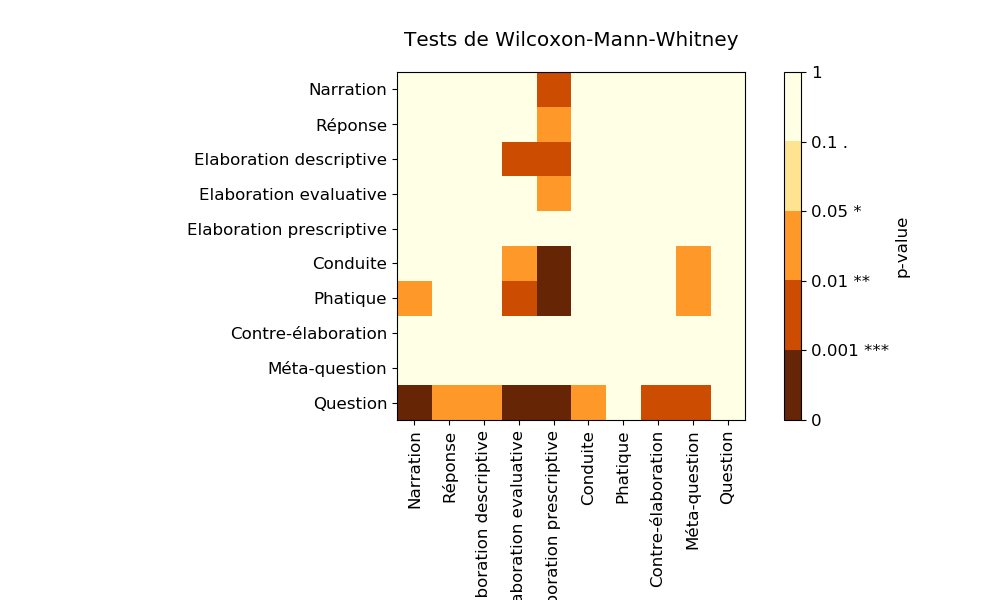

In [24]:
draw_p_values(pValues_relations, "Tests de Wilcoxon-Mann-Whitney")

On observe que quand elle est utilisée, la relation Question est choisie par un nombre d'annotateurs significativement plus imoprtant que tous les autres types de relation (sauf Phatique). C'est donc sans doute le type de relation le plus consensuel.

Etonnamment, la relation Phatique n'est significativement utilisée conjointement par un nombre plus important d'annotateurs que par rapport aux Narrations, Elaborations descriptives et Méta-questions, alors que c'est la relation pour laquelle la médiane était la plus haute et qui semblait la plus étendue vers les valeurs élevée. 

Cependant, ces résultats sont difficiles à interpréter étant donné que les séries contiennent beaucoup de valeurs proches de zéro. En effet, il arrive souvent qu'un annotateur soit seul à choisir un type de relation particulier pour une unité particulière. Il y a donc beaucoup de valeurs proches de 0 mais peu informatives dans la liste des proportions d’utilisation de chaque unité, qui font néanmoins baisser les moyennes et médianes.

Nous avons également essayé une autre approche qui consiste à représenter pour chaque texte la proportion de chaque type de relation en fonction de l’entropie de l’unité dont elle part. Cela permet de visualiser quels sont les types de relations qui sont utilisés aux endroits où l’annotation est la plus consensuelle. Cela permet également de considérer la notion de consensus selon les 3 définitions que nous avons déjà évoqué : consensus sur le type de relation partant de l’unité, sur l’unité de destination, ou sur les deux

In [25]:
def rand_jitter(arr):
    """
    Ajoute un peu de bruit sur les données pour que les points ne soient pas tous superposés
    """
    stdev = .007*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev


def dessinerRelationsParEntropie(nomTexte, critere):
    """
    Dessine le graphe du nombre de chaque relation par unité, triées par entropie
    """
    x = listeEntropies[critere][nomTexte]
    trie = sorted(x.items(), key=operator.itemgetter(1))

    annotations = camp.getAnnotations(nomTexte)
    matriceTotale = annotations[0].matrice().copy()
    for a in annotations[1:]:
        matriceTotale = matriceTotale.add(a.matrice())
        
    fig, ax = plt.subplots(figsize=(12, 6))      
    colors=["red", "blue", "green", "yellow", "orange", "brown", "pink", "grey", "magenta", "tan"]
    markers=["o", "v", "^", "s", "P", "*", "X", "D", "h", "p"]

    relType = list()
    for i, rel in enumerate(camp.typesRelations):
        x = list()
        y = list()
        for origine, entropy in trie:
            x.append(entropy)
            y.append(matriceTotale[rel, origine].sum())
            relType.append(rel)
        ax.scatter(rand_jitter(x), rand_jitter(y), c=colors[i], label=rel, marker=markers[i])

    labels = ["{:.2f}".format(x[1])  + "\n"+ x[0] for x in trie]
    locs = [x[1] for x in trie]
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel("Entropie")
    plt.ylabel("Nombre d'annotations")
    plt.gcf().subplots_adjust(right=0.8)
    plt.show()

In [26]:
interact(dessinerRelationsParEntropie, nomTexte=camp.textes.keys(), critere=["type", "emplacement-type"])

A Jupyter Widget

<function __main__.dessinerRelationsParEntropie>

Pour Florence par type, on voit par exemple que les élaborations descriptives sont majoritaires sur les relations les plus consensuelles. Cependant, le type de relations utilisées dépend beaucoup d’un texte à l’autre, celui-ci comportant beaucoup d’élaborations descriptives mais d’autres beaucoup de phatiques par exemple. Nous n’avons pour l’instant tracé ces graphiques qu’individuellement, pour chaque texte, mais il serait donc intéressant d’étudier également le graphique total combinant les points de tous les autres. 

Nous n’avons pour l’instant cherché que les types de relations qui semblent le plus consensuel dans l’absolu, et on retrouve en effet les mêmes que précédemment. Il serait néanmoins intéressant de chercher également s’il y a des différences sur les relations les plus consensuelles en fonction du mode de calcul de l’entropie : est-ce que les élaborations descriptives sont plus consensuelles au niveau du type de relation, quelle que soit l’unité d’arrivée par exemple, ou est-ce qu’elles le sont à un niveau plus fort : au niveau du type et également de l’unité d’arrivée ?

Encore une fois nous ne savons pas comment traduire toutes ces observations de manière numérique, sans simplement compter le nombre de relations au dessus d’un seuil arbitraire.


# VI. Clusters d'annotateurs

## VI.1. Clusters pour chaque texte

Afin d’estimer des groupes de convergences dans l’annotation des textes par chaque annotateur, il a été décidé de calculer le kappa de cohen pour mesurer l’accord inter annotateur 2 à 2 entre chacune de nos données pour un texte donné.

Dans les annotations, chaque unité est reliée UNE fois par UNE relation, nous avons donc choisi de modéliser les choix de l’annotateur de manière générique des 3 manières suivantes, créant ainsi 3 niveau de “profondeur” d’accord entre les annotateurs :
- A quelle unité est reliée l’unité de départ
- Par quelle relation est reliée l’unité de départ
- A quelle unité et par quelle relation est reliée l’unité de départ
Sur chacune de ses modélisations nous calculons le Kappa de Cohen nous donnant un coefficient de proximité entre deux annotations

Pour créer des sous groupes d’annotations proches, nous avons besoin de créer des regroupement hiérarchique d’annotations.
Pour cela, nous avons besoin de créer des vecteurs d’annotateurs [(A1 → A2), (A1 → A3), (A1 → A4) ...)] et de calculer la distance qui sépare leurs annotations, générant donc une liste de vecteurs de distances entre chaque paire possible d’annotation.
Pour calculer cette distance, nous avons donc transformé le coefficient de proximité entre deux annotations, calculé par le Kappa de Cohen comme expliqué plus haut, en distance en le soustrayant à 1 : $d(u,v) = 1 - K (u, v)$.

Avec la liste des vecteurs obtenus, nous pouvons ensuite calculer nos clusters en utilisant les outils de scipy.cluster.hierarchy : linkage pour calculer les clusters en fonction de nos vecteurs de distances et d’un algorithme de regroupement, et ensuite de dendrogram pour les afficher. Nous avons choisi l’algorithme de regroupement “average” car il est un bon compromis entre les différents algorithmes de regroupements.

Nous obtenons ainsi les graphiques générés ci dessous, représentation des regroupements hiérarchique de chaque annotations pour un texte et une profondeur d’accord donnés

In [27]:
interact(clusteringParTexte, camp = fixed(camp), textname=camp.textes.keys(), critere = {"unité" : 0,"catégorie de relation" : 1,"relation" : 2,"unité-catégorie de relation" : 3,"unité-relation" : 4})

A Jupyter Widget

<function analyse.clusteringParTexte>

Commentaires :

Généralement :
Les cluster avec le Kappa calculé uniquement sur le choix de l’unité d’arrivée sont tous beaucoup plus proches, puis relation, puis la combinaison des deux

Dans Bac à Sable :
On observe toujours deux grands cluster, à chaque fois un peu moins proches en fonction de la profondeur du kappa, et 2 annotations très éloignées des autres.
Il y a même beaucoup d’annotations similaires entre elles en termes de choix d’unités d’arrivée ou des relations la reliant, alors la combinaison des deux réduit considérablement cette observation. il n’y a que 4 et 2 annotations strictement similaires entre elles, toutes les 6 sont dans le même  grand cluster.

Volley et Concours, les témoins :
Il est important de noter que dû au hasard nous avons presque fait annoter 2 fois plus le texte Concours de que Volley
Dans concours même pour une analyse de l’unité et sa relation, nous obtenons 2 bon clusters avec une distance inférieure à 0,5 et 4 annotations à part sur les 12 au total
Volley semble avoir posé plus de problèmes, sur les 24 annotations un groupe de 12 se forme aussi sous le seuil des 0,5, alors que les autres sont plus éloignées, et déjà sur le choix des unités uniquement 3 groupes se distinguent (mais tous restent sous le seuil de 0,5 donc d’un accord modéré)

Florence et Nord, textes à rupture courts :
Plus aucune annotation strictement semblables
Deux clusters pour les distances sur unités uniquement, le tout est assez proche
Sur le 3ème niveau plus de disparités, 3 groupes sous 0,5 dans Nord, 1 gros groupe dans Florence

Sauveur et Provocation, textes à rupture longs :
Encore une fois dû au hasard une légère différence entre le nombre de sauveur et de Provocation doit être notée, 15 fois Provocation contre 20 fois Sauveur
Consensus sur les unités dans un grand groupe pour provocation, 3 dont 2 plus petits dans Sauveur
Consensus plus léger avec un groupe sous les 0,6 dans les deux textes pour ce qui est des relations
La combinaisons des deux crée un grand groupe dans Sauveur près des 0,5 et un sous groupe de 2 annotateur qui reste assez proche de l’autre sous les 0,6
Dans Provocation 3 groupes dont 1 grand sous les 0,5, tous se rejoignent vers 0,7 

## VI.2. Addition de plusieurs textes

In [28]:
interact(clusteringMultipleTextes, critere = {"unité" : 0,"catégorie de relation" : 1,"relation" : 2,"unité-catégorie de relation" : 3,"unité-relation" : 4}, camp = fixed(camp), temoin = ["","Concours","Volley"], rupture1 = ["","Florence","Nord"], rupture2 = ["","Provocation","Sauveur"])

A Jupyter Widget

<function analyse.clusteringMultipleTextes>